# A. Desciption

## Flood-Filling Networks (FFNs) are a class of neural networks designed for instance segmentation of complex and large shapes, particularly in volume EM datasets of brain tissue.

## We are trying to implement FFNs to mouselight data which are acquired from two-photon microscopy. By doing this, we hope to reduce the work of human proofreading for generating masks of large dataset.

# B. Pipeline

## I. prepare for the environment

### (1a) activate the virtual environment for brainlit: (mine is "brainlit" here)

    conda activate brainlit

### (1b) clone the repo:

    git clone https://github.com/google/ffn
    
### (1c) cd into the repo: (all the other commands below should be used in this repo)

    cd ffn
    
### (1d) install the necessary dependencies:

    pip install -r requirements.txt
    
### (1e) create directory "brainlit" in this repo

## II. download data

### (2a) download benchmarking data (no cells) via aws cli on Shreya's tutorial (link below) and save them as local files, the local path I used is "D:/Study/Nuero Data Design/brainlit": 

https://kokes.github.io/nbviewer.js/viewer.html#aHR0cHM6Ly9naXRodWIuY29tL05ldXJvRGF0YURlc2lnbi9icmFpbmxpdC9ibG9iL3NocmV5YV9kbi9kb2NzL25vdGVib29rcy91dGlscy9kb3dubG9hZGluZ19iZW5jaG1hcmtpbmcuaXB5bmI=

### (2b) generate masks for benchmarking data and save them as local files:

https://github.com/NeuroDataDesign/brainlit/blob/lcy/docs/notebooks/notes/generating_image_masks.ipynb

### (2c) download images with cells from s3 and convert them into .h5 files

## III. train the model with test_1 in benchmarking dataset

### (3a) covert benchmarking data into .h5 files

### (3b) preprocess test_1

### (3c) convert the original test_1 and its mask into .h5 files

### (3d) run Script 1

### (3e) run Script 2

### (3f) run Script 3

## IV. the model trained here has different settings from those used in the sample
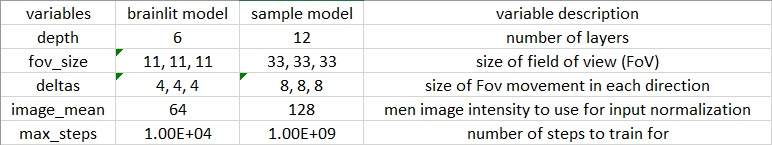

## V. do the inference part

### (5a) do the inference part with images containing cells

### (5b) check results of (5a) via napari

### (5c) do the inference part with images containing no cells

### (5d) check results of (5c) via napari

# C. Codes and Results

## This section contains the detailed description from step (2c) to step (5d) in the last section

In [ ]:
from ffn.utils import bounding_box_pb2
from ffn.inference import storage
from ffn.inference import inference
from ffn.inference import inference_pb2
from ffn.inference import inference_flags

from brainlit.utils.session import NeuroglancerSession
from brainlit.utils.swc import graph_to_paths
from brainlit.viz.visualize import napari_viewer
from google.protobuf import text_format

import numpy as np
import h5py
import os
from skimage import io
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

### (2c) download images with cells from s3 and convert them into .h5 files

In [ ]:
# (2c) download images with cells from s3 and convert them into .h5 files

dir = "s3://open-neurodata/brainlit/brain1"
dir_segments = "s3://open-neurodata/brainlit/brain1_segments"
mip = 0
v_id = 0
radius = 75
seg_ids = np.array([])

for seg_id in range(300):
    ngl_sess = NeuroglancerSession(mip = mip, url = dir, url_segments = dir_segments)
    try:
        img, bbox, vox = ngl_sess.pull_voxel(seg_id, v_id, radius)
        print(f"seg_id = {seg_id}: YES")
        seg_ids = np.append(seg_ids, seg_id)
    except:
        print(f"seg_id = {seg_id}: NO")
        continue
    print(f"\n\nDownloaded volume is of shape {img.shape}, with total intensity {sum(sum(sum(img)))}.")
    save_path = "C:/Users/Tanch/ffn/brainlit/images/cells"
    test_path = save_path + "/image%d.h5" % (seg_id)
    with h5py.File(test_path, 'w') as f:
        f.create_dataset('raw', data = img, compression = 'gzip') 

### (3a) covert benchmarking data into .h5 files

### (3b) preprocess test_1

### (3c) convert the original test_1 and its mask into .h5 files

In [ ]:
# base_dir is the path containing bechmarking data
base_dir = Path("D:/Study/Nuero Data Design/brainlit") 
data_dir = base_dir / "benchmarking_datasets"
im_dir = data_dir / "Images"
mask_dir = base_dir / "benchmarking_masks"
gfp_files = list(im_dir.glob("**/*.tif"))
save_path = "C:/Users/Tanch/ffn/brainlit/images"
test_path = save_path + "/test"
validation_path = save_path + "/validation"
if not os.path.exists(test_path):
    os.makedirs(test_path)
if not os.path.exists(validation_path):
    os.makedirs(validation_path)

# (3a) covert benchmarking data into .h5 files

for im_num, im_path in enumerate(gfp_files):
    file_name = im_path.parts[-1][:-8]
    print(file_name)
    if file_name[:10] != "validation":
        print("it's test img")
        im = io.imread(im_path, plugin="tifffile")
        im = np.swapaxes(im, 0, 2)
        mask_file = file_name + "_mask.tif"
        mask_path = mask_dir / mask_file
        mask = io.imread(mask_path, plugin="tifffile")
        test_file = test_path + "/" + file_name + ".h5"
        with h5py.File(test_file, 'w') as f:
            f.create_dataset('raw', data = im, compression = 'gzip') 
            f.create_dataset('mask', data = mask, compression = 'gzip')
    else:
        print("it's validation img")
        im = io.imread(im_path, plugin="tifffile")
        im = np.swapaxes(im, 0, 2)
        mask_file = file_name + "_mask.tif"
        mask_path = mask_dir / mask_file
        mask = io.imread(mask_path, plugin="tifffile")
        val_file = validation_path + "/" + file_name + ".h5"
        with h5py.File(val_file, 'w') as f:
            f.create_dataset('raw', data = im, compression = 'gzip') 
            f.create_dataset('mask', data = mask, compression = 'gzip')

# (3b) preprocess test_1

im_num = 0 # take test_1
im_path = gfp_files[im_num]
print(f"The image used for training: {im_path}")
im = io.imread(im_path, plugin="tifffile")
im = np.swapaxes(im, 0, 2)
file_name = im_path.parts[-1][:-8]
mask_file = file_name + "_mask.tif"
mask_path = mask_dir / mask_file
mask = io.imread(mask_path, plugin="tifffile")
# The list of allowed values: 
#     bfloat16, float16, float32, float64, uint8, int8, int16, int32, int64, 
#     complex64, quint8, qint8, qint32, string, bool, complex128
im = im.astype("int16")
mask = mask.astype("int32")

# (3c) convert the original test_1 and its mask into .h5 files

train_dir = "C:/Users/Tanch/ffn/brainlit/images/" + file_name
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
train_path = train_dir + "/grayscale_maps.h5"
with h5py.File(train_path, 'w') as f:
    f.create_dataset('raw', data = im, compression = 'gzip') 
mask_path = train_dir + "/groundtruth.h5"
with h5py.File(mask_path, 'w') as f:
    f.create_dataset('stack', data = mask, compression = 'gzip') 

### (3d) run Script 1:

    python compute_partitions.py \
        --input_volume brainlit/images/test_1/groundtruth.h5:stack \
        --output_volume brainlit/images/test_1/af.h5:af \
        --thresholds 0.025,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9 \
        --lom_radius 24,24,24 \
        --min_size 10000

### this will create af.h5 with key "af"

### (3e) run Script 2:

    python build_coordinates.py \
         --partition_volumes validation1:brainlit/images/test_1/af.h5:af \
         --coordinate_output brainlit/images/test_1/tf_record_file \
         --margin 24,24,24

### this will create tf_record_file

### thus, there are grayscale_maps.h5, groundtruth.h5, af.h5 and tf_record_file in directory "C:/Users/Tanch/ffn/brainlit/images/test_1"

### train the model with prepared files above

### (3f) run Script 3:

    python train.py \
        --train_coords brainlit/images/test_1/tf_record_file \
        --data_volumes validation1:brainlit/images/test_1/grayscale_maps.h5:raw \
        --label_volumes validation1:brainlit/images/test_1/groundtruth.h5:stack \
        --model_name convstack_3d.ConvStack3DFFNModel \
        --model_args "{\"depth\": 6, \"fov_size\": [11, 11, 11], \"deltas\": [4, 4, 4]}" \
        --image_mean 64 \
        --image_stddev 33
        
### the model will be created in ffn/tmp with the largest checkpoint number. rename this directory as test_1 and put it into path brainlit/models
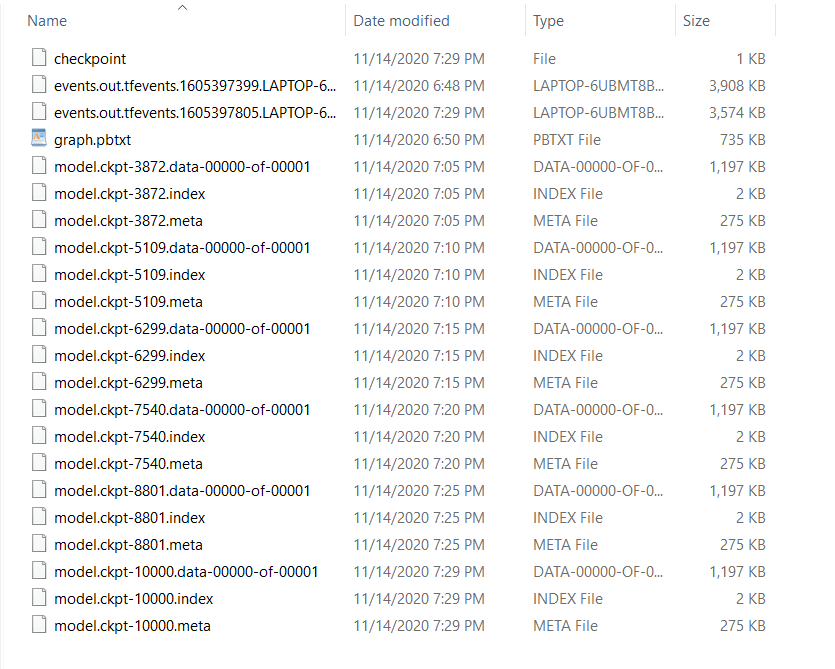

### (5a) do the inference part with images containing cells

In [ ]:
# (5a) do the inference part with images containing cells

results_path = "C:/Users/Tanch/ffn/brainlit/results/test_1/cells"
if not os.path.exists(result_path):
    os.makedirs(result_path)
napari_view = False
for seg_id in seg_ids:
    warnings.filterwarnings("ignore")
    seg_id = int(seg_id)
    print(f"current seg_id = {seg_id}...")
    result_path = results_path + "/" + str(seg_id)
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    result_path = result_path + "/0"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    
    config = '''image {
      hdf5: "brainlit/images/cells/image%d.h5:raw"
    }
    image_mean: 64
    image_stddev: 33
    checkpoint_interval: 1800
    seed_policy: "PolicyPeaks"
    model_checkpoint_path: "brainlit/models/test_1/model.ckpt-10000"
    model_name: "convstack_3d.ConvStack3DFFNModel"
    model_args: "{\\"depth\\": 6, \\"fov_size\\": [11, 11, 11], \\"deltas\\": [4, 4, 4]}"
    segmentation_output_dir: "brainlit/results/test_1/cells/%d"
    inference_options {
      init_activation: 0.95
      pad_value: 0.05
      move_threshold: 0.9
      min_boundary_dist { x: 1 y: 1 z: 1}
      segment_threshold: 0.6
      min_segment_size: 1000
    }''' % (seg_id, seg_id)
    req = inference_pb2.InferenceRequest()
    _ = text_format.Parse(config, req)

    runner = inference.Runner()
    runner.start(req)
    canvas, alignment = runner.make_canvas((0, 0, 0), (150, 150, 150))

    bbox = bounding_box_pb2.BoundingBox()
    bounding_box = 'start { x:0 y:0 z:0 } size { x:150 y:150 z:150 }'
    text_format.Parse(bounding_box, bbox)

    runner.run((bbox.start.z, bbox.start.y, bbox.start.x), (bbox.size.z, bbox.size.y, bbox.size.x))

### (5b) check results of (5a) via napari

In [ ]:
# (5b) check results of (5a) via napari

for seg_id in seg_ids:
    filename = "brainlit/images/cells/image%d.h5" % (seg_id)
    with h5py.File(filename, "r") as f:
        data = list(f["raw"])
        img = np.array(data)

    seg, _ = storage.load_segmentation('brainlit/results/test_1/cells/%d' % (seg_id), (0, 0, 0))
    seg2 = seg
    seg2 = np.int64(seg2>0)
    print(f"seg_id = {seg_id}")
    print(f"The number of labels: {sum(sum(sum(seg2)))}")
    if napari_view:
        napari_viewer(img, labels=seg2)

#### seg_id = 60 (origin)
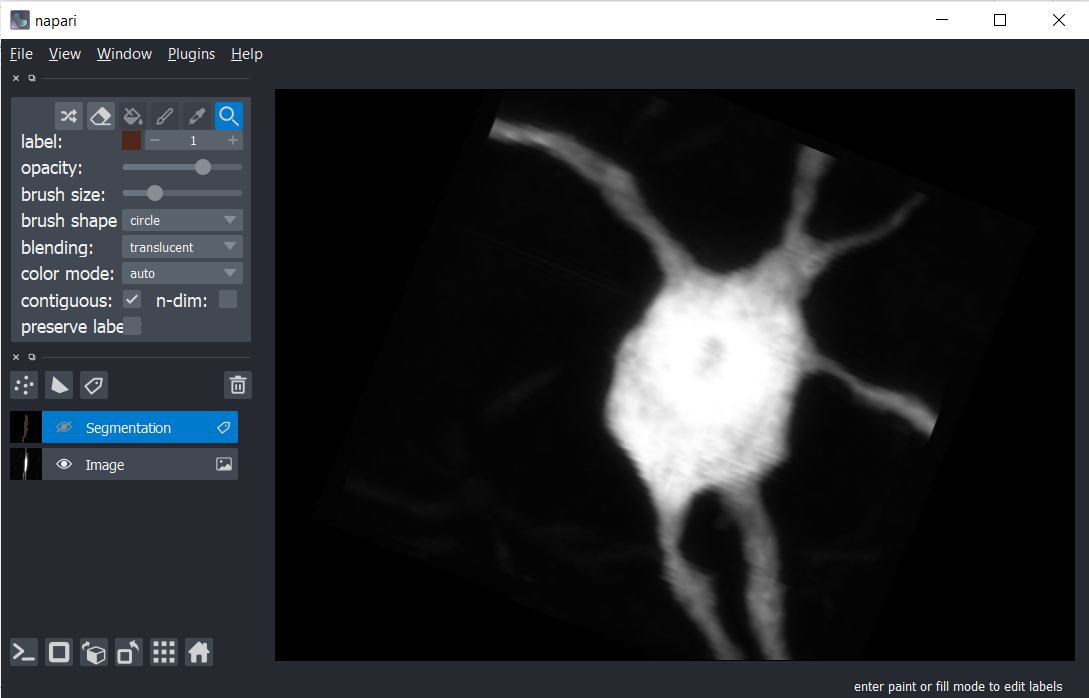

#### seg_id = 60 (with mask)
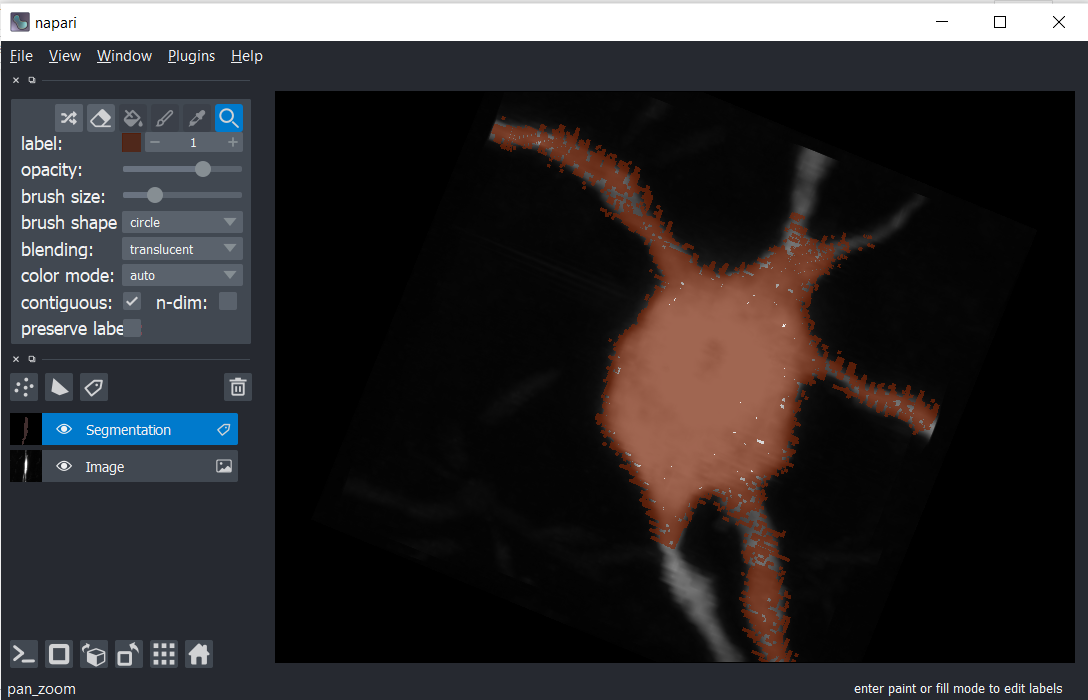

#### seg_id = 81 (origin)
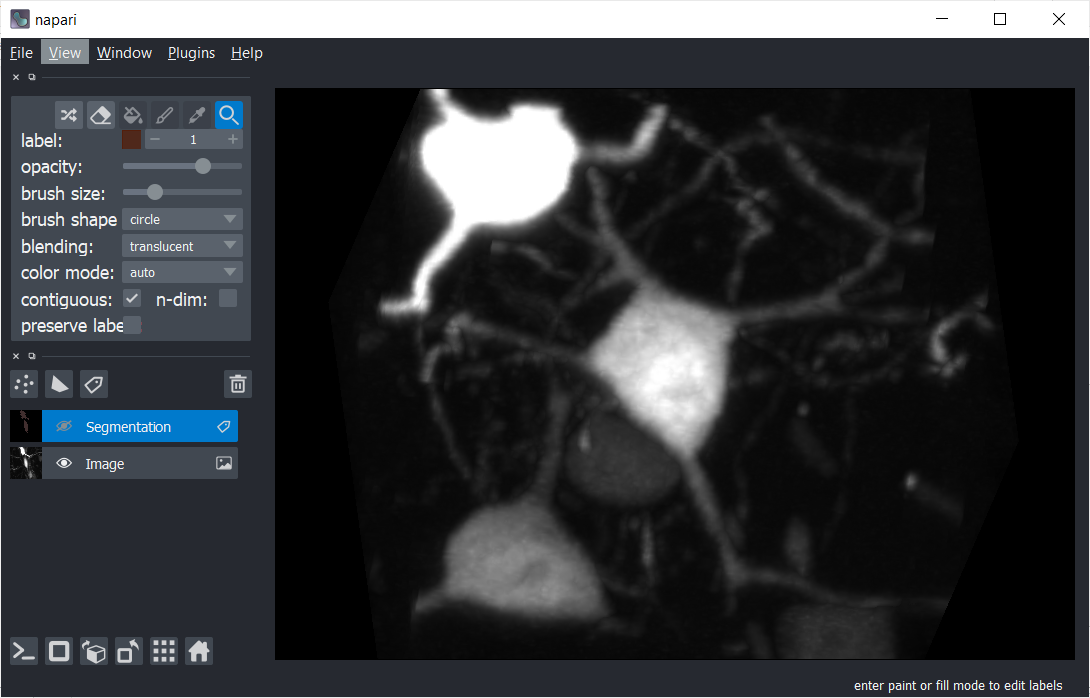

#### seg_id = 81 (with mask)
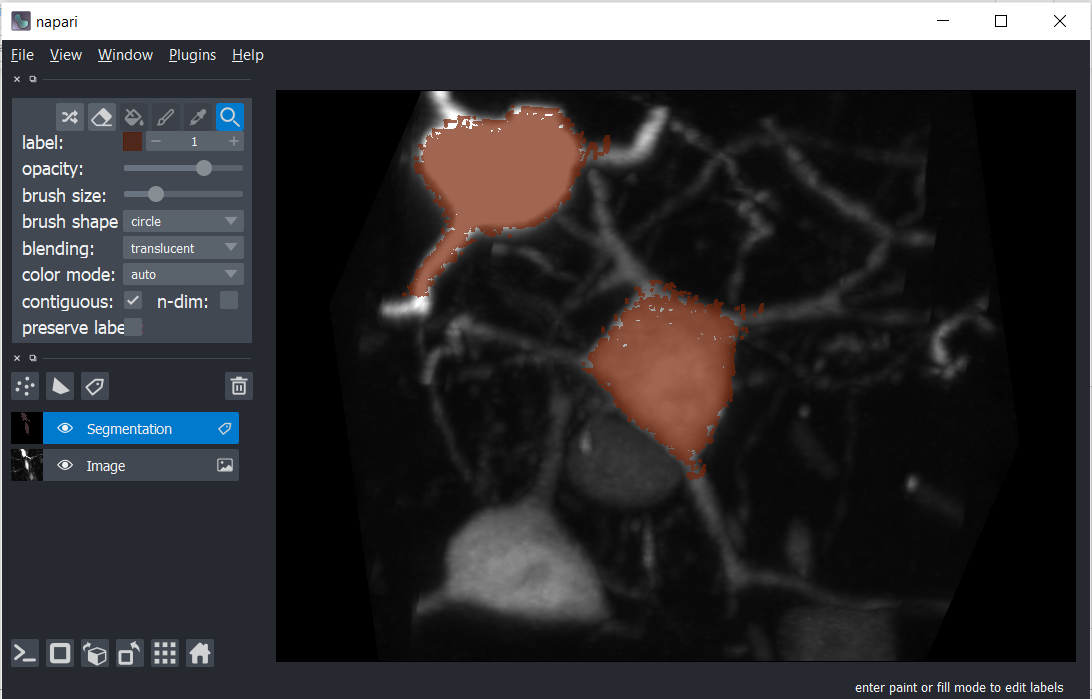

#### seg_id = 271 (origin, no mask in the corresponding result)
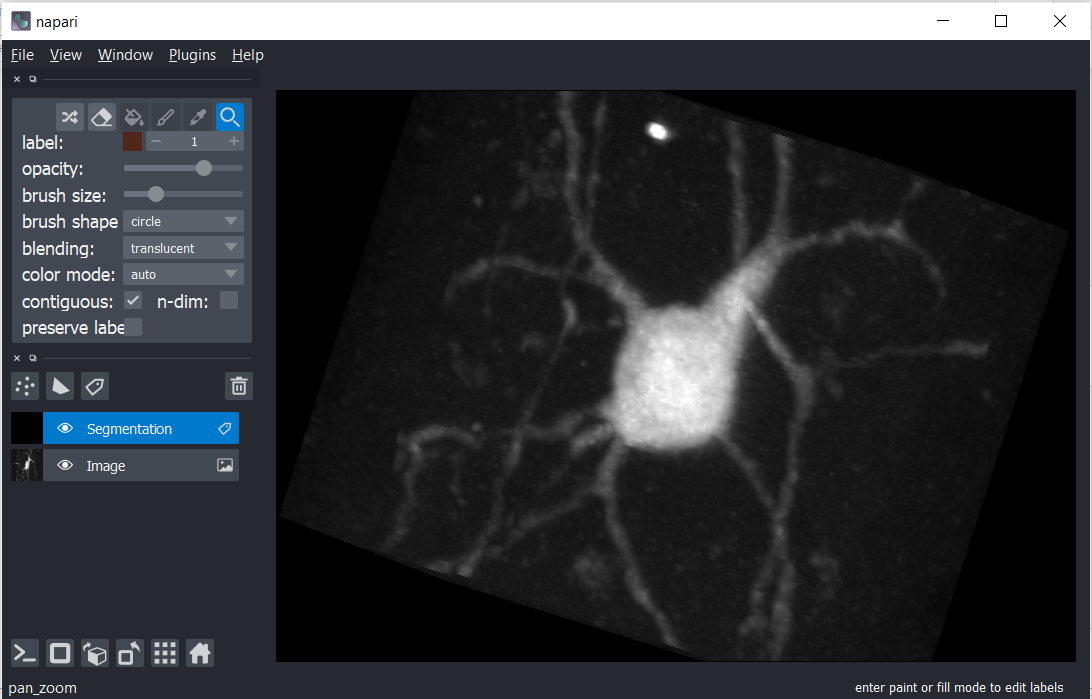

### (5c) do the inference part with images containing no cells

In [ ]:
# (5c) do the inference part with images containing no cells

result_path = "C:/Users/Tanch/ffn/brainlit/results"
if not os.path.exists(result_path):
    os.makedirs(result_path)
for i in range(25):
    i += 1
    test_path = result_path + "/test_" + str(i)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    for j in range(25):
        j += 1
        val_path = test_path + "/validation_" + str(j)
        if not os.path.exists(val_path):
            os.makedirs(val_path)
        val_path += "/0"
        if not os.path.exists(val_path):
            os.makedirs(val_path)
            
for im_num in range(25):
    im_num += 1
    config = '''image {
      hdf5: "brainlit/images/validation/validation_%d.h5:raw"
    }
    image_mean: 64
    image_stddev: 33
    checkpoint_interval: 1800
    seed_policy: "PolicyPeaks"
    model_checkpoint_path: "brainlit/models/test_1/model.ckpt-10000"
    model_name: "convstack_3d.ConvStack3DFFNModel"
    model_args: "{\\"depth\\": 6, \\"fov_size\\": [11, 11, 11], \\"deltas\\": [4, 4, 4]}"
    segmentation_output_dir: "brainlit/results/test_1/validation_%d"
    inference_options {
      init_activation: 0.95
      pad_value: 0.05
      move_threshold: 0.9
      min_boundary_dist { x: 1 y: 1 z: 1}
      segment_threshold: 0.6
      min_segment_size: 1000
    }''' % (im_num, im_num)
    req = inference_pb2.InferenceRequest()
    _ = text_format.Parse(config, req)
    
    runner = inference.Runner()
    runner.start(req)
    canvas, alignment = runner.make_canvas((0, 0, 0), (330, 330, 100))
    
    bbox = bounding_box_pb2.BoundingBox()
    bounding_box = 'start { x:0 y:0 z:0 } size { x:330 y:330 z:100 }'
    text_format.Parse(bounding_box, bbox)
    
    runner.run((bbox.start.z, bbox.start.y, bbox.start.x), (bbox.size.z, bbox.size.y, bbox.size.x))

### (5d) check results of (5c) via napari

In [ ]:
# (5d) check results of (5c) via napari

for im_num in range(25):
    im_num += 1
    seg, _ = storage.load_segmentation('brainlit/results/test_1/validation_%d' % im_num, (0, 0, 0))
    seg2 = seg
    seg2 = np.int64(seg2 > 0)
    
    filename = "brainlit/images/validation/validation_%d.h5" % im_num
    with h5py.File(filename, "r") as f:
        data = list(f["raw"])
        img = np.array(data)
        data = list(f["mask"])
        mask = np.array(data)

    print(f"im_num = {im_num}")
    print(f"The number of labels: {sum(sum(sum(seg2)))}")    
    if napari_view:
        napari_viewer(img, labels=seg2)

#### validation_25 (origin, no mask in the corresponding result)
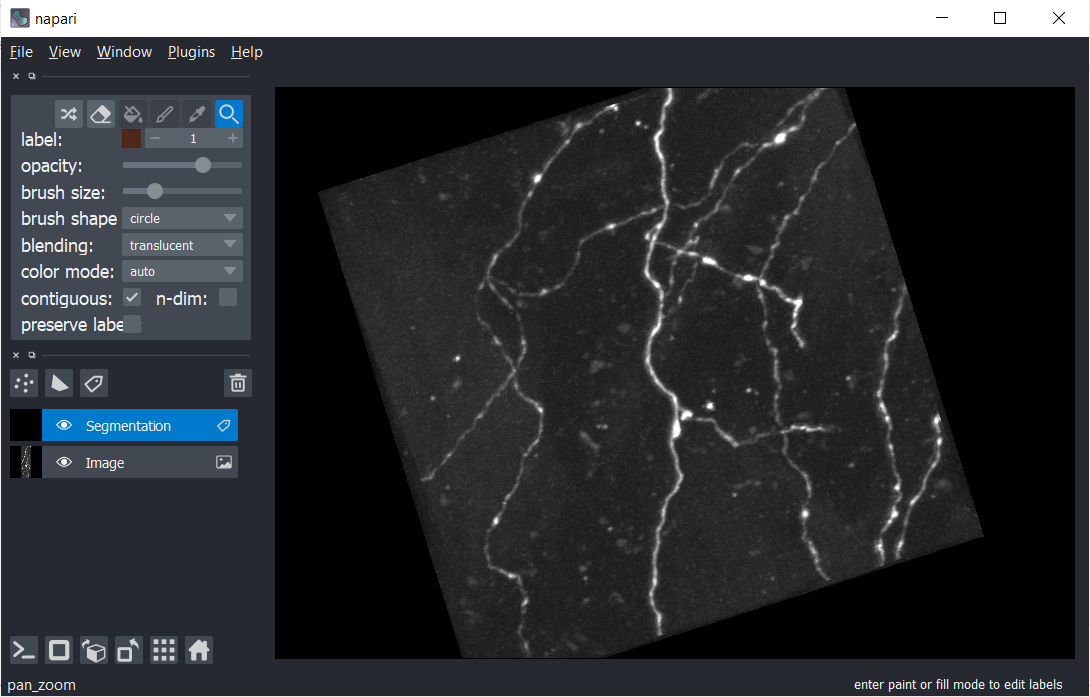

# D. Discussion

## I. The model

### We used different settings to train the model, and acquired a model with a smaller size for mouselight data compared with that used for EM data in author's sample. The comparision can be seen in part B.IV. Because of this, the results of our data would be less precise and we can improve the results by changing the settings to get a model with larger size.

## II. Data with cells

### Most of the results contain masks for the original data, and the visualized examples are images with seg_id 60 and 81 in part B.IV.5b and part C. The model can generate masks for images with a single cell and also images with several cells.

### A few of results don't contain any mask for the original data, and the visualized example is image with seg_id 271 in part B.IV.5b and part C. One possible reason could be that there are too many noises in the background of the original images.

## III. Data without cells

### None of the results contain any mask for the original data, and the visualized example is image validation_25 in part B.IV.5d and part C.

# E. Ways to Improve

## I. Train the model with more images at the same time

### We could combine several images into a larger image and use it as the training data.

## II. Change the settings to get a model with larger size

### The most important parts could be increasing the number of network layers and also the maximum number of steps.

## III. Train the model with images containing noises in the background

### We could manually generate masks for image with seg_id 271 and use it as the training data.

# ps: all the images shown in this notebook could be found in the path doc/experiment/ffn/